In [259]:
import pandas as pd
import numpy as np

In [260]:
gen = pd.read_csv('Challenge1_GroupX_best.csv', sep=";", decimal=",") #Change sep at will
gen["ds"] = pd.to_datetime(gen["ds"])
gen.rename(columns={"Energia": "Production"}, inplace=True)
gen.head()

,ds,Production
0,2024-09-01 00:00:00,0.0
1,2024-09-01 01:00:00,0.0
2,2024-09-01 02:00:00,0.0
3,2024-09-01 03:00:00,0.0
4,2024-09-01 04:00:00,0.0


In [261]:
conS = pd.read_csv('datasets/Consumo_fotovoltaica.csv')
conS["FECHA"] = pd.to_datetime(conS["FECHA"])
conS.rename(columns={"TOTAL_KWH_ENERGIA": "Solar Consumption"}, inplace=True)
conS.head()

,FECHA,Solar Consumption
0,2024-09-01 00:00:00+02:00,0.0
1,2024-09-01 01:00:00+02:00,0.0
2,2024-09-01 02:00:00+02:00,0.0
3,2024-09-01 03:00:00+02:00,0.0
4,2024-09-01 04:00:00+02:00,0.0


In [262]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

conT = pd.read_csv('datasets/Consumo_sept.csv')
conT["FECHA"] = pd.to_datetime(conT["FECHA"])
conT.rename(columns={"FECHA": "ds", "TOTAL_KWH_ENERGIA" : "Total Consumption"}, inplace=True)
conT["Total Consumption"] = imputer.fit_transform(conT[["Total Consumption"]])

In [263]:
carb = pd.read_csv('datasets/ES_2024_hourly.csv')
carb = carb[["Datetime (UTC)", "Carbon Intensity gCO₂eq/kWh (direct)"]]
carb["Datetime (UTC)"] = pd.to_datetime(carb["Datetime (UTC)"])
carb.rename(columns={"Datetime (UTC)": "ds", "Carbon Intensity gCO₂eq/kWh (direct)": "Carbon Intensity"}, inplace=True)
carb.head()

,ds,Carbon Intensity
0,2024-01-01 00:00:00,93.63
1,2024-01-01 01:00:00,93.64
2,2024-01-01 02:00:00,98.90
3,2024-01-01 03:00:00,99.33
4,2024-01-01 04:00:00,102.59


In [264]:
conS['FECHA'] = conS['FECHA'].dt.tz_localize(None)  # Remove timezone
gen['ds'] = gen['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

In [265]:
gen = gen.merge(conS, left_on='ds', right_on='FECHA', how='left')
gen["Solar Diff"] = gen["Production"] - gen["Solar Consumption"]
gen = gen.merge(conT, on='ds', how='left')
gen = gen.merge(carb, on='ds', how='left')
gen["CO2 Emmitted"] = gen["Carbon Intensity"] * gen["Total Consumption"]
gen.drop('FECHA', axis=1, inplace=True)
gen.head()

,ds,Production,Solar Consumption,Solar Diff,Total Consumption,Carbon Intensity,CO2 Emmitted
0,2024-09-01 00:00:00,0.0,0.0,0.0,110.855888,170.04,18849.935258
1,2024-09-01 01:00:00,0.0,0.0,0.0,107.341202,175.13,18798.664668
2,2024-09-01 02:00:00,0.0,0.0,0.0,105.550308,175.53,18527.245603
3,2024-09-01 03:00:00,0.0,0.0,0.0,106.840103,174.22,18613.682771
4,2024-09-01 04:00:00,0.0,0.0,0.0,105.879791,175.05,18534.257460


In [266]:
gen.shape

(720, 7)

In [267]:
print(min(gen["Carbon Intensity"]))
print(max(gen["Carbon Intensity"]))
print(max(gen["Carbon Intensity"]-min(gen["Carbon Intensity"])))

32.77
183.41
150.64


In [268]:
gen['Hour'] = gen['ds'].dt.hour  # Extract the hour from the datetime column
average_carbon_per_hour = gen.groupby('Hour')['Carbon Intensity'].mean().reset_index()
average_carbon_per_hour.rename(columns={'Carbon Intensity': 'Average Carbon Intensity'}, inplace=True)
average_carbon_per_hour.sort_values('Average Carbon Intensity', ascending=False, inplace=True)
print(average_carbon_per_hour)

    Hour  Average Carbon Intensity
19    19                131.106667
18    18                127.927000
20    20                125.151333
6      6                122.005333
5      5                119.962000
21    21                116.302000
4      4                114.549000
3      3                109.836667
2      2                106.495333
22    22                106.356333
1      1                105.423667
0      0                104.519667
23    23                102.135000
17    17                101.876333
7      7                 98.531333
8      8                 70.118333
16    16                 69.581667
9      9                 56.952333
15    15                 55.761667
10    10                 52.597333
14    14                 51.729667
11    11                 51.269667
13    13                 50.418333
12    12                 50.035333


In [269]:
average_solar_per_hour = gen.groupby('Hour')['Production'].mean().reset_index()
average_solar_per_hour.rename(columns={'Production': 'Avg Production'}, inplace=True)
average_solar_per_hour.sort_values('Avg Production', ascending=False, inplace=True)
print(average_solar_per_hour)

    Hour  Avg Production
14    14       89.855575
13    13       89.829537
15    15       88.730320
16    16       84.918525
12    12       79.961103
17    17       75.636464
18    18       60.495948
11    11       58.633596
19    19       42.121317
10    10       30.023625
20    20       16.688621
9      9        9.789461
21    21        5.535858
8      8        1.394146
1      1        0.000000
0      0        0.000000
7      7        0.000000
6      6        0.000000
5      5        0.000000
4      4        0.000000
3      3        0.000000
2      2        0.000000
22    22        0.000000
23    23        0.000000


In [270]:
gen.drop(columns=['Hour'], inplace=True)
gen.head()

,ds,Production,Solar Consumption,Solar Diff,Total Consumption,Carbon Intensity,CO2 Emmitted
0,2024-09-01 00:00:00,0.0,0.0,0.0,110.855888,170.04,18849.935258
1,2024-09-01 01:00:00,0.0,0.0,0.0,107.341202,175.13,18798.664668
2,2024-09-01 02:00:00,0.0,0.0,0.0,105.550308,175.53,18527.245603
3,2024-09-01 03:00:00,0.0,0.0,0.0,106.840103,174.22,18613.682771
4,2024-09-01 04:00:00,0.0,0.0,0.0,105.879791,175.05,18534.257460


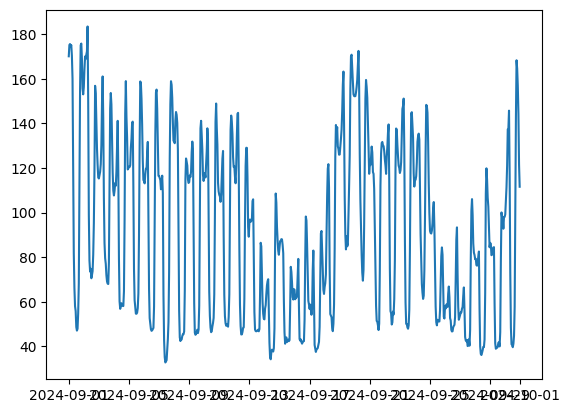

In [271]:
import matplotlib.pyplot as plt

plt.plot(gen["ds"], gen["Carbon Intensity"])
plt.show()

In [272]:
battery_limit = 100
daily_charge = 0
daily_discharge = 0
current_battery = 0
charge_list = []
discharge_list = []
battery_level_list = []

In [273]:
for index, row in gen.iterrows():
    timestamp = row["ds"]
    solar_diff = row["Solar Diff"]
    total_consumption = row["Total Consumption"]

    # Initialize charge and discharge amounts
    charge_amount = 0
    discharge_amount = 0

    # Charge the battery if Solar Diff is positive and no discharge occurs in the same hour
    if solar_diff > 0 and (index == 0 or discharge_list[-1] == 0):
        charge_amount = min(solar_diff, battery_limit - current_battery, battery_limit - daily_charge)
        current_battery += charge_amount
        daily_charge += charge_amount

    # Discharge starting from 18:00, based on Total Consumption, and only if no charging happened this hour
    if timestamp.hour >= 18 and current_battery > 0 and charge_amount == 0:
        discharge_amount = min(total_consumption, current_battery, battery_limit - daily_discharge)
        current_battery -= discharge_amount
        daily_discharge += discharge_amount

    # Store charge, discharge, and battery level
    charge_list.append(charge_amount)
    discharge_list.append(discharge_amount)
    battery_level_list.append(current_battery)

    # Reset daily charge and discharge at midnight
    if timestamp.hour == 0:
        daily_charge = 0
        daily_discharge = 0

# Add new columns to gen
gen["Current Battery Level"] = battery_level_list
gen["Battery Charge"] = charge_list
gen["Battery Discharge"] = discharge_list
gen["Reduction Energy Consumed From Grid"] = gen["Total Consumption"] - gen["Battery Discharge"]
gen["CO2 Optimised"] = gen["Reduction Energy Consumed From Grid"] * gen["Carbon Intensity"]

In [274]:
gen.head()

,ds,Production,Solar Consumption,Solar Diff,Total Consumption,Carbon Intensity,CO2 Emmitted,Current Battery Level,Battery Charge,Battery Discharge,Reduction Energy Consumed From Grid,CO2 Optimised
0,2024-09-01 00:00:00,0.0,0.0,0.0,110.855888,170.04,18849.935258,0.0,0.0,0.0,110.855888,18849.935258
1,2024-09-01 01:00:00,0.0,0.0,0.0,107.341202,175.13,18798.664668,0.0,0.0,0.0,107.341202,18798.664668
2,2024-09-01 02:00:00,0.0,0.0,0.0,105.550308,175.53,18527.245603,0.0,0.0,0.0,105.550308,18527.245603
3,2024-09-01 03:00:00,0.0,0.0,0.0,106.840103,174.22,18613.682771,0.0,0.0,0.0,106.840103,18613.682771
4,2024-09-01 04:00:00,0.0,0.0,0.0,105.879791,175.05,18534.257460,0.0,0.0,0.0,105.879791,18534.257460


In [275]:
#gen.to_csv('Challenge2_OVER.csv') #Change sep at will

In [276]:
ra = (gen["Solar Consumption"].sum()+gen["Battery Discharge"].sum())/gen["Production"].sum()
print(ra)

1.05327315916479
